In [26]:
import numpy as np
import pandas as pd
import os, re, glob
from itertools import chain
import matplotlib.pyplot as plt
import jiwer

from util.helpers import create_directory


from config.constants import Constants
CONSTANTS = Constants(local=True)


## Get mapping of sample name to label -> for group-wise analysis later

In [27]:
def get_metadata_from_file_path(file_path):
    metadata = {}

    # train or test
    try:
        split = re.match(r".*/(train|test|test-dist)/.*", file_path).group(1)
        metadata["split"] = split
    except:
        metadata["split"] = None

    # dementia or control
    try:
        group = re.match(r".*/(cd|cc|ad)/.*", file_path).group(1)
        metadata["group"] = group
    except:
        metadata["group"] = None

    metadata['file'] = os.path.basename(file_path)

    return metadata

def get_mapping():
    from dataloader.dataloader import ADReSSDataLoader
    dataloader = ADReSSDataLoader(local=True)
    manual_train, manual_test = dataloader.load_data()
    mapping = pd.DataFrame({'audio_file_path': np.concatenate((manual_train.data, manual_test.data)),
                            'basename':
                                [get_metadata_from_file_path(path)['file'] for path in manual_train.data] +
                                [get_metadata_from_file_path(path)['file'] for path in manual_test.data],
                            'label': np.concatenate((manual_train.labels, manual_test.labels))
                            })

    mapping['sample_name'] = mapping['basename'].apply(lambda row: row[:row.index(".")])
    return mapping

mapping = get_mapping()
mapping

Initializing dataloader ADReSS audio
Loading data using dataloader ADReSS audio


,audio_file_path,basename,label,sample_name
0,/Users/jheitz/phd/data/dementiabank_extracted/...,S143.wav,1,S143
1,/Users/jheitz/phd/data/dementiabank_extracted/...,S156.wav,1,S156
2,/Users/jheitz/phd/data/dementiabank_extracted/...,S142.wav,1,S142
3,/Users/jheitz/phd/data/dementiabank_extracted/...,S154.wav,1,S154
4,/Users/jheitz/phd/data/dementiabank_extracted/...,S140.wav,1,S140
...,...,...,...,...
151,/Users/jheitz/phd/data/dementiabank_extracted/...,S203.wav,1,S203
152,/Users/jheitz/phd/data/dementiabank_extracted/...,S204.wav,0,S204
153,/Users/jheitz/phd/data/dementiabank_extracted/...,S205.wav,1,S205
154,/Users/jheitz/phd/data/dementiabank_extracted/...,S206.wav,0,S206


## Load preprocessed manual transcripts


In [28]:

def get_manual_transcriptions():
    transcriptions = []

    # Traverse the directory and its subdirectories
    # e92f43 = {'only_PAR': False, 'keep_pauses': False, 'keep_terminators': True, 'keep_unintelligable_speech': False, 'runtime': '2023-09-20 15:20'}
    # 4f7384 = {'only_PAR': True, 'keep_pauses': False, 'keep_terminators': True, 'keep_unintelligable_speech': False, 'runtime': '2023-09-20 15:19'}
    for root, dirs, files in os.walk('/Volumes/methlab/Students/Jonathan/data_preprocessed/transcriptions/manual/_raw_ADReSS_manual_transcripts/4f7384'):
        # Filter the files for .txt extension
        txt_files = glob.glob(os.path.join(root, '*.txt'))

        # Read the content of each .txt file
        for file_path in txt_files:
            metadata = get_metadata_from_file_path(file_path)
            with open(file_path, 'r') as file:
                content = file.read()
                path = os.path.basename(file_path)
                sample_name = path[:path.index(".")]
                if sample_name != "info":
                    transcriptions.append(pd.Series({'file': path, 'sample_name': sample_name, 'manual': content}))

    return pd.concat(transcriptions, axis=1).T

manual = get_manual_transcriptions()
manual

,file,sample_name,manual
0,S180.txt,S180,well the boy is taking cookies out of the cook...
1,S187.txt,S187,hm it's a little boy climbing up getting some ...
2,S189.txt,S189,alright . uh the little girl s wants cookie . ...
3,S201.txt,S201,well the boy is getting cookies and he's gonna...
4,S206.txt,S206,well for one thing the boy is stealing cookies...
...,...,...,...
151,S055.txt,S055,the boy's uh the girl's making fun of the boy ...
152,S029.txt,S029,action . alright . a lady's drying dishes . th...
153,S067.txt,S067,okay . the boy is taking cookies out of a clos...
154,S015.txt,S015,all of the action you see going on . okay . th...


## Load different ASR transcriptions

In [29]:
def get_ASR_transcriptions(base_dirs, manual, version_name):
    transcriptions = []

    # Traverse the directory and its subdirectories
    for root, dirs, files in chain.from_iterable(os.walk(d) for d in base_dirs):
        # Filter the files for .txt extension
        txt_files = glob.glob(os.path.join(root, '*.txt'))
        #print(sorted([os.path.basename(f) for f in txt_files]), len([os.path.basename(f) for f in txt_files]))

        # Read the content of each .txt file
        for file_path in txt_files:

            with open(file_path, 'r') as file:
                metadata = get_metadata_from_file_path(file_path)
                content = file.read()
                try:
                    # remove metadata at beginning of file by splitting by double line break and taking the second part, if available
                    content = content[content.index("\n\n")+2:]
                except:
                    pass
                # remove punctuation
                content = re.sub(r"[.,?!]", "", content)
                # normalize white spaces
                content = re.sub(r"\s+", " ", content).strip()
                content = content.lower()
                path = os.path.basename(file_path)
                sample_name = path[:path.index(".")]
                if sample_name != "info":
                    transcriptions.append(pd.Series({'file': path, 'sample_name': sample_name, 'transcript': content, 'version': version_name}))

    concat = pd.concat(transcriptions, axis=1).T
    return concat.merge(manual.drop(columns=["file"]), on="sample_name", how="outer")


In [30]:
# Load Google Speech
google = get_ASR_transcriptions([f'/Volumes/methlab/Students/Jonathan/data_preprocessed/transcriptions/google_speech/v1_9ae494/{d}' for d in ['_raw_ADReSS_audio_test_-_Audio_Cutter', '_raw_ADReSS_audio_train_-_Audio_Cutter']], manual, "google")
google

,file,sample_name,transcript,version,manual
0,S194.txt,S194,well the mother has water spilling all over th...,google,well the mother has water spilling all over th...
1,S193.txt,S193,okay the kid on the bench who's got his hand i...,google,okay the kid on the bench who's got his hand i...
2,S177.txt,S177,cookie jar uh a lad standing on a stool teteri...,google,cookie jar . uh a lad standing on a stool teet...
3,S170.txt,S170,this woman is saying what she dish is standing...,google,I s see this woman who's standing by the sink ...
4,S179.txt,S179,see it's running over well yeah here's some si...,google,well the table the seat is falling . the sink ...
...,...,...,...,...,...
151,S125.txt,S125,,google,mhm . oh . there's a cookie jar . and the boy ...
152,S122.txt,S122,oh sure the little girl standing in the kitche...,google,oh sure . the little girl's standing in the ki...
153,S110.txt,S110,now honey i had was in the kitchen and i was t...,google,now honey I w l l ha w had it was in the kitch...
154,S097.txt,S097,an average home that looks very much like ours...,google,an average home that looks very much like ours...


In [31]:
whisper = get_ASR_transcriptions([f'/Volumes/methlab/Students/Jonathan/data_preprocessed/transcriptions/whisper-large/v1_4a8dc1/{d}' for d in ['_raw_ADReSS_audio_test_-_Audio_Cutter', '_raw_ADReSS_audio_train_-_Audio_Cutter']], manual, "whisper")
whisper

,file,sample_name,transcript,version,manual
0,S174.txt,S174,i see a little boy on a stool almost falling o...,whisper,I see a little boy on a stool almost falling o...
1,S173.txt,S173,a little boy is getting himself some cookies o...,whisper,a little boy is getting himself some cookies o...
2,S199.txt,S199,the two children are in the process of stealin...,whisper,there's um the two children are in the process...
3,S197.txt,S197,okay anywhere the little girl's laughing the l...,whisper,okay . anywhere ? um the little girl's laughin...
4,S190.txt,S190,i get that andgeraldis drying those dishes rig...,whisper,um the girl's in the trying hm did I get that ...
...,...,...,...,...,...
151,S080.txt,S080,okay,whisper,okay he's falling off a chair . she's uh runni...
152,S087.txt,S087,elaine and her children the father isn't comin...,whisper,hm a lady a lady and her children . children ....
153,S100.txt,S100,okay there's a cook a boy is taking cookies an...,whisper,okay . uh there's a cook a b a boy's a boy is ...
154,S089.txt,S089,she was upset what's going on over in this are...,whisper,so she will find her . and the mother washes d...


In [32]:
wave2vec2 = get_ASR_transcriptions([f'/Volumes/methlab/Students/Jonathan/data_preprocessed/transcriptions/wave2vec-large/v1_4a8dc1/{d}' for d in ['_raw_ADReSS_audio_test_-_Audio_Cutter', '_raw_ADReSS_audio_train_-_Audio_Cutter']], manual, "wave2vec2")
wave2vec2

,file,sample_name,transcript,version,manual
0,S187.txt,S187,live by climbing up gin o cook at cook a lot t...,wave2vec2,hm it's a little boy climbing up getting some ...
1,S180.txt,S180,well the boys eh takin cookies out the cookie ...,wave2vec2,well the boy is taking cookies out of the cook...
2,S189.txt,S189,but et ewe it still wisd eto still i e ben sho...,wave2vec2,alright . uh the little girl s wants cookie . ...
3,S206.txt,S206,well for one thing the boy is stealing cookies...,wave2vec2,well for one thing the boy is stealing cookies...
4,S201.txt,S201,mell the boy is getting cookies and he's going...,wave2vec2,well the boy is getting cookies and he's gonna...
...,...,...,...,...,...
151,S143.txt,S143,well little boy um richin oug for the cooky ja...,wave2vec2,well little boy throat reaching out for the co...
152,S129.txt,S129,well anl the kid's up takin cookies out of the...,wave2vec2,well the kid's up taking cookies out of the co...
153,S127.txt,S127,can the ladies wash in the distrat ligt they a...,wave2vec2,okay . the lady's washing the dishes like they...
154,S095.txt,S095,tell me ow an a ya don der what comes olit wol...,wave2vec2,and I will tell you what's g oh boy . well the...


## Calculate Word Error Rate (WER)

Using jiwer package, also CER, which we don't use...

In [33]:
def calculate_wer(transcription):
    def calculate_row(fct, row):
        try:
            return fct(row.manual, row.transcript)
        except:
            return None
    transcription['WER'] = transcription.apply(lambda row: calculate_row(jiwer.wer, row), axis=1)  # word error rate
    transcription['CER'] = transcription.apply(lambda row: calculate_row(jiwer.cer, row), axis=1)  # character error rate
    return transcription


In [34]:
# Example, for one ASR
with pd.option_context('display.max_colwidth', 2000):
    display(calculate_wer(wave2vec2))

,file,sample_name,transcript,version,manual,WER,CER
0,S187.txt,S187,live by climbing up gin o cook at cook a lot toe cooke jor and i lives u to reach a pason an live wash down on a low and it bis us to washing edision at the ank dik sis washing the dichonit's got she got da dises on this siing on the sant not thank sheis a running water an ila dit er livs us tes ar rechin johnnys at johnny hes ar hes up on a louto er ge gettin some cook es in ther lives us to reaching up reach reaching a bapsol he he i ye pason down to her and en now rit ta dout about to turn o on egos de cup so at you er maybe she dem to wash him if she gon sidting on i on the saint and maybe run maye runnin water on the sank and ye got hishon got a got a cook the pool that she might get some might in i ans dicos tedichos taked up it might be on the sint not even allrighty,wave2vec2,hm it's a little boy climbing up getting some coo cookies out of the cookie jar . and his little sister reaching for some . and the little boy is standing on a ladder . and his big sister washing the dishes at the sink . big sister washing the dishes and then she got she got uh dishes on the s sitting on the sink . and I think she's uh running water . and I said the uh little sister's uh reach Johnny's Johnny he is uh he is up on the ladder uh get getting some cookies and the little sister reaching up reach reaching up after some . he he he he's passing it down to her . and the ladder the ladder about to turn over . the k uh this the cups what she's uh sh maybe she going to wash them and she got them sitting on the on the sink . and maybe running maybe running water on the sink and they got if she got a got a curtain to pull that she might get some light in there . since dishes the dishes stacked up . they might be on the sink . no that be about all .,0.708134,0.386528
1,S180.txt,S180,well the boys eh takin cookies out the cookie jar while the the stool is ready to a ball over the girl is reachin fer cooki e the mother is looking out of the window while the water runs over from the sink yes what feet standing in the water at's the actual devicy unnaturally the stool falls over the voyage going to all in flora,wave2vec2,well the boy is taking cookies out of the cookie jar while the the stool is ready to uh fall over . the girl is reaching for a cookie . uh the mother is looking out the window while the water runs over from the sink . she has wet feet standing in the water . that's the action that I see . well naturally the stool falls over the boy is going to fall on the floor .,0.430380,0.189041
2,S189.txt,S189,but et ewe it still wisd eto still i e ben shon at cn me is e bowin on away him mo e atis ismoe by monto i now way she sat er astha oeat mo same soo i ee i,wave2vec2,alright . uh the little girl s wants cookie . the boy is getting her one but the s stool is going to he's going to fall off the stool . it's tilty . uh the mother is doing the dishes . and unfortunately the sink is overflowing on the floor . it's wet . . . the little b oh that's his feet . I thought there was something around the little boy's foot or at least at least just one part of one foot foot on top of the other . the little girl I I don't whether she's laughing or asking for the cookie or saying “shh” so mother doesn't hear them .,0.974138,0.790055
3,S206.txt,S206,well for one thing the boy is stealing cookies and the girl is asking for cookie and the boy is standing on her stool which is tipping over and the lady's drying her plate endthe water is running in the sink and overflowing ong her floor and getting her feet wet and the window is open in i don't know that there's anything special going on outside the window seems to me that that's essentially the things that are going on in this picture the girl is picking her nose the boy is handing her cookie really those are the only activities i see,wave2vec2,well for one thing the boy is stealing cookies . and the girl is asking for a cookie . and the boy 

### Plot box plot of distribution of WER for each ASR sytem

With and without outliers

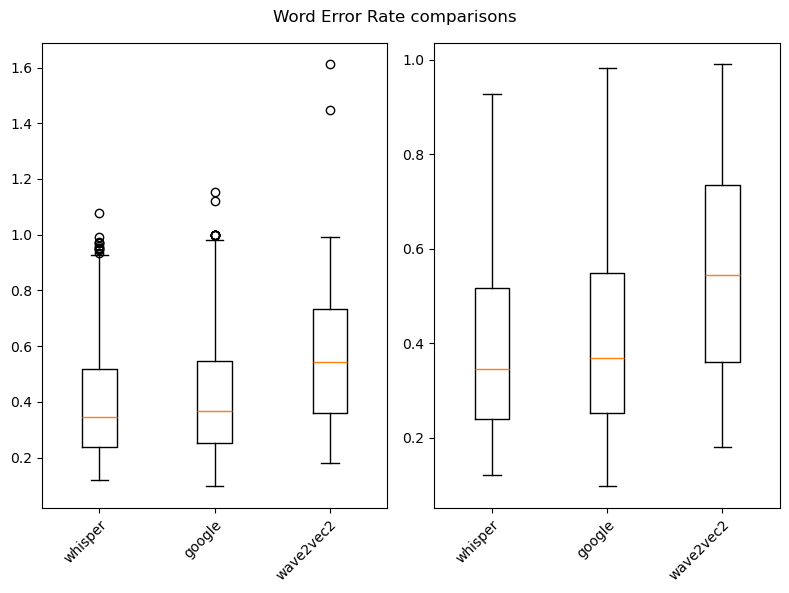

In [35]:
def plot_metrics(metric_name, experiment_name, *transcriptions):

    metric_name_mapping = {
        'WER': "Word Error Rate",
        'CER': "Character Error Rate"
    }
    metric_name_full = metric_name_mapping.get(metric_name, metric_name)

    metrics = {}
    for t in transcriptions:
        version = t['version'][0]
        #print("Version:", version)
        if t.query("transcript.isna()").shape[0] > 0:
            print(f"NA transcriptions for sample {t.query('transcript.isna()')['sample_name']}")
            t = t.query("not transcript.isna()").copy()
        m = calculate_wer(t)[metric_name]
        metrics[version] = m

    # positions: i + a gap between each group. Make sure it's sorted by group, otherwise the positions logic doesnt work
    groups = [0 if 'adress' in metric_name else 1 for metric_name in metrics]
    assert sorted(groups) == groups
    positions = [i+groups[i] for i in range(len(groups))]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,6))
    fig.suptitle(f'{metric_name_full} comparisons')
    ax1.boxplot(metrics.values(), positions=positions)
    ax1.set_xticklabels(metrics.keys(), rotation=45, ha='right', rotation_mode='anchor')
    ax2.boxplot(metrics.values(), sym="", positions=positions)
    ax2.set_xticklabels(metrics.keys(), rotation=45, ha='right', rotation_mode='anchor')
    plt.tight_layout()

    create_directory("plots")
    experiment_name_part = experiment_name.replace(" ", "_").lower()
    plt.savefig(f"plots/{experiment_name_part}_{metric_name}-transcriptions.png")
    plt.show()

plot_metrics('WER', 'ASR comparison', whisper, google, wave2vec2)
#plot_metrics('CER', 'ASR comparison', whisper, google, wave2vec2)





## Load gender and age information for each sample_name

In [36]:
# get gender and age

metadata_raw = [{'path': os.path.join(CONSTANTS.DATA_ADReSS_ROOT, "test", "meta_data_with_labels.csv"), 'label': None},
                {'path': os.path.join(CONSTANTS.DATA_ADReSS_ROOT, "train", "cd_meta_data.txt"), 'label': 1},
                {'path': os.path.join(CONSTANTS.DATA_ADReSS_ROOT, "train", "cc_meta_data.txt"), 'label': 0}]

dfs = []
for d in metadata_raw:
    path, label = d['path'], d['label']
    df = pd.read_csv(path, sep=";")
    if label is not None:
        df['Label'] = label
    df = df.rename(columns={c: c.strip() for c in df.columns}).rename(columns={'ID': 'sample_name'})
    dfs.append(df)
participant_metadata = pd.concat(dfs)
participant_metadata.sample_name = participant_metadata.sample_name.str.strip()
participant_metadata.gender = np.where(participant_metadata.gender.str.strip().isin(['female', "1", 1]), 1, np.where(participant_metadata.gender.str.strip().isin(['male', "0", 0]), 0, participant_metadata.gender)) # 1 female, 0 male
participant_metadata

participant_metadata.gender.value_counts(dropna=False)

gender
1    86
0    70
Name: count, dtype: int64

## Plot distribution of WER for each ASR and group

In [37]:
combined = pd.concat([whisper, google, wave2vec2])
combined = combined.sort_values(by="file").drop(columns=['transcript','manual'])
combined = combined.merge(participant_metadata, on="sample_name", how="left")
combined['Label'] = combined['Label'].astype(str)
combined

,file,sample_name,version,WER,CER,age,gender,Label,mmse
0,S001.txt,S001,wave2vec2,0.304348,0.122736,74,0,0,NA
1,S001.txt,S001,google,0.193237,0.089537,74,0,0,NA
2,S001.txt,S001,whisper,0.193237,0.102616,74,0,0,NA
3,S002.txt,S002,whisper,0.970874,0.900383,62,1,0,30
4,S002.txt,S002,google,1.000000,1.000000,62,1,0,30
...,...,...,...,...,...,...,...,...,...
463,S206.txt,S206,wave2vec2,0.200000,0.082312,65,0,0,28
464,S206.txt,S206,whisper,0.158333,0.070053,65,0,0,28
465,S207.txt,S207,wave2vec2,1.612245,1.153527,57,1,0,27
466,S207.txt,S207,whisper,0.959184,0.721992,57,1,0,27


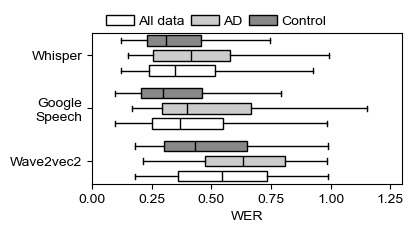

In [175]:
import matplotlib.patches as mpatches

def plot_metrics_for_paper2(combined):


    #with plt.rc_context({"text.usetex": True, "font.family": "sans-serif", "font.sans-serif": "Arial", "font.size": 10}):
    with plt.rc_context({"font.family": "sans-serif", "font.sans-serif": "Arial", "font.size": 10}):
        # one column is 7.7 cm
        cm = 1/2.54
        fig, (ax2) = plt.subplots(1, 1, figsize=(7.7*1.3*cm,5.5*cm))
        #fig.suptitle(f'{metric_name_full} comparisons')


        label_positions = []
        labels = []
        for subgroup in ['all', 'dementia', 'control']:
            for i, version in enumerate(combined.version.drop_duplicates()):
                base_position = i*3.5
                if subgroup == 'all':
                    values = combined.query(f"version == '{version}'").WER
                    position = base_position
                    boxprops = dict(facecolor='#fff')
                    label_positions.append(base_position + 1)
                    labels.append(version.replace("_adress", "").replace("wave2vec2", 'Wave2vec2').replace("google", 'Google\nSpeech').replace("whisper", 'Whisper'))
                elif subgroup == 'dementia':
                    values = combined.query(f"version == '{version}' and Label == '1'").WER
                    position = base_position + 1
                    boxprops = dict(facecolor='#ccc')
                elif subgroup == 'control':
                    values = combined.query(f"version == '{version}' and Label == '0'").WER
                    position = base_position + 2
                    boxprops = dict(facecolor='#888')
                ax2.boxplot(values, sym="", positions=[position], vert=False, widths=0.7, boxprops=boxprops, medianprops=dict(color='#000'), patch_artist=True)

                #ax2.text(1.27, position-0.1, f"{np.median(values):.2f}", ha="right", va="center", fontsize="9", backgroundcolor="white", linespacing=1,
                #          bbox=dict(boxstyle='square,pad=-0.1', fc=(1,1,1,0.7), ec="none"))

        # custom legend
        all = mpatches.Patch(facecolor='#fff', edgecolor='#000', label='All data')
        dementia = mpatches.Patch(facecolor='#ccc', edgecolor='#000', label='AD')
        control = mpatches.Patch(facecolor='#888', edgecolor='#000', label='Control')
        plt.legend(handles=[all, dementia, control], fontsize=10, ncol=3, loc='upper center', bbox_to_anchor=(0.4,1.2), columnspacing=0.5, frameon=False, handletextpad=0.3)


        ax2.set_xlabel("WER")
        ax2.set_yticks(label_positions, labels)#, rotation=45, ha='right', rotation_mode='anchor')
        ax2.set_xticks([0, .25, .5, .75, 1, 1.25])
        ax2.set_xlim([0,1.3])
        plt.tight_layout(pad=0)
        

        plt.savefig(f"plots/ASR_WER_with_subgroups2.pdf")
        plt.show()

plot_metrics_for_paper2(combined)

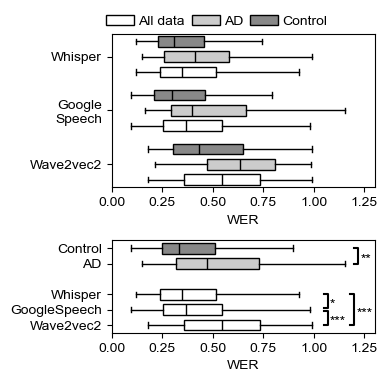

In [189]:
import matplotlib.patches as mpatches
from matplotlib.gridspec import GridSpec

def plot_metrics_for_paper3(combined):


    #with plt.rc_context({"text.usetex": True, "font.family": "sans-serif", "font.sans-serif": "Arial", "font.size": 10}):
    with plt.rc_context({"font.family": "sans-serif", "font.sans-serif": "Arial", "font.size": 10}):
        # one column is 7.7 cm
        cm = 1/2.54
        
        #fig, (ax2) = plt.subplots(1, 1, figsize=(7.7*1.3*cm,5.5*cm))
        #fig = plt.figure(layout="constrained", figsize=(7.7*1.3*cm,10*cm))
        #gs = GridSpec(2, 2, figure=fig)
        #ax1 = fig.add_subplot(gs[0, :])
        #ax2 = fig.add_subplot(gs[1, 0])
        #ax3 = fig.add_subplot(gs[1:, 1])
        
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7.7*1.3*cm,10*cm), height_ratios=(2,1.2))
        

        label_positions = []
        labels = []
        for subgroup in ['all', 'dementia', 'control']:
            for i, version in enumerate(combined.version.drop_duplicates()):
                base_position = i*3.5
                if subgroup == 'all':
                    values = combined.query(f"version == '{version}'").WER
                    position = base_position
                    boxprops = dict(facecolor='#fff')
                    label_positions.append(base_position + 1)
                    labels.append(version.replace("_adress", "").replace("wave2vec2", 'Wave2vec2').replace("google", 'Google\nSpeech').replace("whisper", 'Whisper'))
                elif subgroup == 'dementia':
                    values = combined.query(f"version == '{version}' and Label == '1'").WER
                    position = base_position + 1
                    boxprops = dict(facecolor='#ccc')
                elif subgroup == 'control':
                    values = combined.query(f"version == '{version}' and Label == '0'").WER
                    position = base_position + 2
                    boxprops = dict(facecolor='#888')
                ax1.boxplot(values, sym="", positions=[position], vert=False, widths=0.7, boxprops=boxprops, medianprops=dict(color='#000'), patch_artist=True)
                
        # custom legend
        all = mpatches.Patch(facecolor='#fff', edgecolor='#000', label='All data')
        dementia = mpatches.Patch(facecolor='#ccc', edgecolor='#000', label='AD')
        control = mpatches.Patch(facecolor='#888', edgecolor='#000', label='Control')
        ax1.legend(handles=[all, dementia, control], fontsize=10, ncol=3, loc='upper center', bbox_to_anchor=(0.4,1.2), columnspacing=0.5, frameon=False, handletextpad=0.3)

        ax1.set_yticks(label_positions, labels)#, rotation=45, ha='right', rotation_mode='anchor')
        ax1.set_xticks([0, .25, .5, .75, 1, 1.25])
        ax1.set_xlim([0,1.3])
        ax1.set_xlabel("WER")


        
        labels = []
        label_positions = []
        for i, version in enumerate(combined.version.drop_duplicates()):
            base_position = i
            values = combined.query(f"version == '{version}'").WER
            position = base_position
            boxprops = dict(facecolor='#fff')
            label_positions.append(position)
            labels.append(version.replace("_adress", "").replace("wave2vec2", 'Wave2vec2').replace("google", 'GoogleSpeech').replace("whisper", 'Whisper'))
            ax2.boxplot(values, sym="", positions=[position], vert=False, widths=0.7, boxprops=boxprops, medianprops=dict(color='#000'), patch_artist=True)
        values = combined.query(f"Label == '1'").WER
        position = base_position + 2
        label_positions.append(position)
        labels.append("AD")
        boxprops = dict(facecolor='#ccc')
        ax2.boxplot(values, sym="", positions=[position], vert=False, widths=0.7, boxprops=boxprops, medianprops=dict(color='#000'), patch_artist=True)
        values = combined.query(f"Label == '0'").WER
        position = base_position + 3
        label_positions.append(position)
        labels.append("Control")
        boxprops = dict(facecolor='#888')
        ax2.boxplot(values, sym="", positions=[position], vert=False, widths=0.7, boxprops=boxprops, medianprops=dict(color='#000'), patch_artist=True)
        
        ax2.set_yticks(label_positions, labels, linespacing=1)#, rotation=45, ha='right', rotation_mode='anchor')
        ax2.set_xlim([0,1.3])
        ax2.set_xticks([0, .25, .5, .75, 1, 1.25])
        ax2.set_xlabel("WER")

        plt.tight_layout(pad=1)


        # combinations of significance levels, see below
        significance_combinations = [
            {'label1': 'GoogleSpeech', 'label2': 'Whisper', 'pval': 3.662094e-02},
            {'label1': 'GoogleSpeech', 'label2': 'Wave2vec2', 'pval': 4.070221e-27},
            {'label1': 'AD', 'label2': 'Control', 'pval': 1.335560e-03},
            {'label1': 'Whisper', 'label2': 'Wave2vec2', 'pval': 6.259286e-38, 'x_offset': 0.13},
        ]
        
        
        # Significance bars
        for i, significant_combination in enumerate(significance_combinations):
            label1, label2, pval = significant_combination['label1'], significant_combination['label2'], significant_combination['pval']
            y1 = label_positions[labels.index(significant_combination['label1'])]
            y2 = label_positions[labels.index(significant_combination['label2'])]
            y1, y2 = min(y1, y2), max(y1, y2)
            
            if y1 == 1:
                y1 = y1 + 0.1
            elif y2 == 1:
                y2 = y2 - 0.1
            
            # Significance level
            if pval < 0.001:
                sig_symbol = '***'
            elif pval < 0.01:
                sig_symbol = '**'
            elif pval < 0.05:
                sig_symbol = '*'

            x_position = 1.2
            if y2 <= 3:
                x_position = 1.05
            if 'x_offset' in significant_combination:
                x_position += significant_combination['x_offset']
            
            ax2.text(x_position+0.03,(y1+y2)/2-0.25, sig_symbol, ha='left', va='center')
            ax2.plot([x_position, x_position+0.02, x_position+0.02, x_position], [y1, y1, y2, y2], c="black")

    
                            


        plt.savefig(f"plots/ASR_WER_with_subgroups_and_significance.pdf")
        plt.show()

plot_metrics_for_paper3(combined)

In [177]:
combined.groupby('version').WER.agg(['mean', 'median'])

,mean,median
version,,
google,0.444228,0.368993
wave2vec2,0.568781,0.544004
whisper,0.420091,0.346009


## Statistical testing of significance

In [184]:
#  Generalized linear mixed-effect model to test for statistical effects of ASR system, diagnosis (AD: label = 1, Control: label = 0).

import statsmodels.formula.api as smf
md = smf.mixedlm("WER ~ ASR + age + gender + Label", combined.rename(columns={"version":"ASR"}),
                 groups=combined["sample_name"])
mdf = md.fit(method=["lbfgs"])
print(mdf.summary())


           Mixed Linear Model Regression Results
Model:               MixedLM  Dependent Variable:  WER     
No. Observations:    468      Method:              REML    
No. Groups:          156      Scale:               0.0104  
Min. group size:     3        Log-Likelihood:      174.3157
Max. group size:     3        Converged:           Yes     
Mean group size:     3.0                                   
-----------------------------------------------------------
                 Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------
Intercept         0.633    0.185  3.412 0.001  0.269  0.996
ASR[T.wave2vec2]  0.125    0.012 10.785 0.000  0.102  0.147
ASR[T.whisper]   -0.024    0.012 -2.090 0.037 -0.047 -0.002
gender[T.1]       0.012    0.037  0.320 0.749 -0.061  0.085
Label[T.1]        0.118    0.037  3.208 0.001  0.046  0.191
age              -0.004    0.003 -1.387 0.166 -0.009  0.002
Group Var         0.050    0.073                   

In [183]:
mdf.pvalues

Intercept           1.030060e-03
ASR[T.google]       3.662094e-02
ASR[T.wave2vec2]    6.259286e-38
Label[T.1]          1.335560e-03
age                 1.655365e-01
gender              7.493160e-01
Group Var           2.465504e-11
dtype: float64

In [23]:
# so yes, label seems to have a significant effect overall

In [24]:
# let's see overall if the models are significantly different, using a paired test for three groups = one-way repeated measures ANOVA
from statsmodels.stats import anova

md = anova.AnovaRM(combined, depvar='WER', subject='sample_name', within=['version'])#, between=["age"])
mdf = md.fit()
print(mdf.summary())

                Anova
        F Value Num DF  Den DF  Pr > F
--------------------------------------
version 95.4769 2.0000 310.0000 0.0000


In [ ]:
# yes, very significant!